# Выбор локации для скважины

**Имеются** пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.<br /> 
**Требуется** провести анализ возможной прибыли и рисков добычи в каждом регионе и, на основе его результатов, выбрать регион, в котором бурение новой скважины принесёт наибольшую прибыль.

**Дополнительные условия**:<br />
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбрать регион с наибольшей средней прибылью.

# Описание данных:

id — уникальный идентификатор скважины;<br />
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);<br />
product — объём запасов в скважине (тыс. баррелей).

# Вспомогательные функции:

### Импорт библиотек

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score 
)
from sklearn.preprocessing import (
    StandardScaler, #
    MinMaxScaler #
)

%matplotlib notebook
%matplotlib inline

In [3]:
# Отключение warning
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
#Формат float
pd.options.display.float_format = '{:,.2f}'.format
# Сброс ограничений на число столбцов
pd.options.display.max_columns = None


Отключение вывода в окно с прокруткой:

In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

### Информация о столбцах:

In [5]:
data_name = 'Данные о скважинах'
data_fields = {
    'id': ['Уникальный идентификатор скважины', False],
    'f0': ['Признак №0', True],
    'f1': ['Признак №1', True],
    'f2': ['Признак №2', True],
    'product': ['Объём запасов в скважине (тыс. баррелей)', True]
}


### Функция, создающая таблицу по данным describe() для столбцов датафрейма

id — уникальный идентификатор скважины;
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
product — объём запасов в скважине (тыс. баррелей).

In [6]:
def describer(df,clmn='column'):
    df_describe = pd.DataFrame(columns=[clmn,'count','mean','std','min','25%','50%','75%','max'])
    for col in df.columns:
        param = df[col]
        typer = type(list(param)[0]) #[0])
        if (not 'str' in str(typer)) and (not 'bool' in str(typer)) and (not 'date' in str(typer)):
            desc = df[col].describe().to_dict()
            desc[clmn] = col
            df_describe = df_describe.append(desc, ignore_index=True)
    return df_describe

### Функция получения информации о столбце

In [7]:
def col_reaper(ddf,param_name,plot_hist = True):
    global data_fields
    data_len = len(ddf)
    param = ddf[param_name]
    
    #Определение имени столбца
    if data_fields.get(param_name)[0] is not None:
        field = data_fields.get(param_name)[0]
    else:
        field = ''
        
    #Описание данных
    print('')
    print('\033[4m'+'Описание данных:'+ '\033[0m')
    print(param.describe(datetime_is_numeric=True))
    typer = type(param[0])
    print('\033[4m' +  'Количество записей:' + '\033[0m', sum(param.notna()), 'из', data_len)
    if sum(param.isna()) >0:
       print('\033[4m' +  'Пропущено:' + '\033[0m', sum(param.isna()))
       print('')

    #Построение гистограммы
    print('\033[4m'+'\nТип:\n' + '\033[0m', typer)
#    if plot_hist and not 'str' in str(typer):
#        print('\nГистограмма значений:')
#        param.hist();
    if plot_hist and not 'str' in str(typer):
            print('\033[4m'+'\nГистограмма значений:'+ '\033[0m')
            param.plot(kind='hist',bins=50,figsize=(16,5), grid = True)
            plt.title(field)
            #plt.xlabel('Населенные пункты') 
            plt.ylabel('Количество записей')
            plt.xticks(rotation=0)
            plt.show()
            
    else:
        if len(param.unique())<=40:
            #param_index = param.reset_index()
            print('\033[4m'+'\nРаспределение уникальных значений (первые 10 значений в порядке убывания):'+ '\033[0m')
            param_group=ddf.groupby(param_name).agg(cnt=(param_name,'count')).reset_index()
            display(param_group.sort_values(by='cnt',ascending=False).reset_index(drop=True).head(10))
            
            print('\033[4m'+'\nГистограмма значений:'+ '\033[0m')
            param_group.plot(x=param_name, y='cnt', kind='bar',figsize=(16,5))
            plt.title(field)
            plt.xlabel('') 
            plt.ylabel('Количество записей')
            if len(param.unique())<=20:
                plt.xticks(rotation=0)
            else:
                plt.xticks(rotation=90)
            plt.show()
    print('')
    

### Функция получения информации о датафрейме

In [8]:
def df_reaper(df, df_name ='', data_fields = {}):
    #global data_fields
    #global df_name
    #global descript
    
    # Список столюцов для гистограмм, диаграмм, корелляции и т.п.
    cols = df.columns
    #print(data_fields)
    true_cols = []
    for col in cols:
        #print(col,data_fields.get(col))
        if data_fields.get(col)[1]:
            true_cols.append(col)

    print('\033[1;4m' +  df_name + '\033[0m \n')   
    print('\033[1m' +  'Количество записей:' + '\033[0m')   
    df_len = len(df)
    display(df_len)
    print('')
    
    print('\033[1m' +  'Первые 5 строк данных:' + '\033[0m')   
    display(df.head())
    print('')
    
    print('\033[1m' +  'Информация о датафрейме:' + '\033[0m')
    print('')
    display(df.info())
    
    print('\033[1m' +  'Описание данных в столбцах с числовыми значениями:' + '\033[0m')
    #display(describer(df[true_cols]))
    display(df.describe().T)

    print('\033[1m' +  'Диаграмма рассеивания:' + '\033[0m')
    pd.plotting.scatter_matrix(df[true_cols], figsize=(16, 16)); 
    plt.show()
    
    print('\033[1m' +  'Корелляция данных:' + '\033[0m')
#    display(df[true_cols].corr())
    
    plt.figure(figsize=(16, 6))
    # define the mask to set the values in the upper triangle to True
    mask = np.triu(np.ones_like(df[true_cols].corr(), dtype=np.bool))
    heatmap = sns.heatmap(df[true_cols].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    #heatmap.set_title('Корелляция данных', fontdict={'fontsize':18}, pad=16);
    plt.show()
    
    print('\033[1m' +  'Столбцы:' + '\033[0m \n')
 #   cols = df.columns

    for col in cols:
        if data_fields.get(col)[0] is not None:
            field = data_fields.get(col)[0]
        else:
            field = ''
        print('\033[1;3m' +  col + ' - ' + field + '\033[0m')
        plot_hist = data_fields.get(col)[1]
        col_reaper(df,col,plot_hist)

## **Загрузка и подготовка данных**

### **Регион №1**

#### Загрузка датасета

In [9]:
data_1 = pd.read_csv('datasets/geo_data_0.csv')

#### Анализ датасета

Данные о скважинах региона №1 

Количество записей:


100000


Первые 5 строк данных:


,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04



Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Описание данных в столбцах с числовыми значениями:


,count,mean,std,min,25%,50%,75%,max
f0,"100,000.00",0.50,0.87,-1.41,-0.07,0.50,1.07,2.36
f1,"100,000.00",0.25,0.50,-0.85,-0.20,0.25,0.70,1.34
f2,"100,000.00",2.50,3.25,-12.09,0.29,2.52,4.72,16.00
product,"100,000.00",92.50,44.29,0.00,56.50,91.85,128.56,185.36


Диаграмма рассеивания:


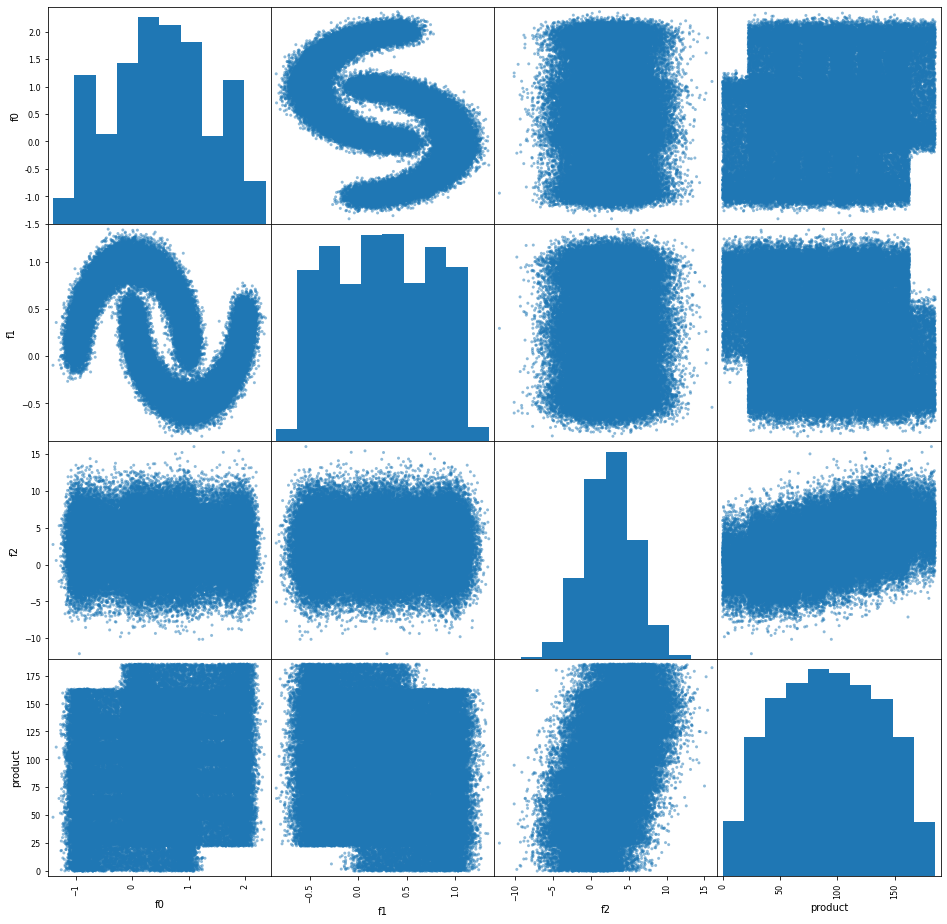

Корелляция данных:


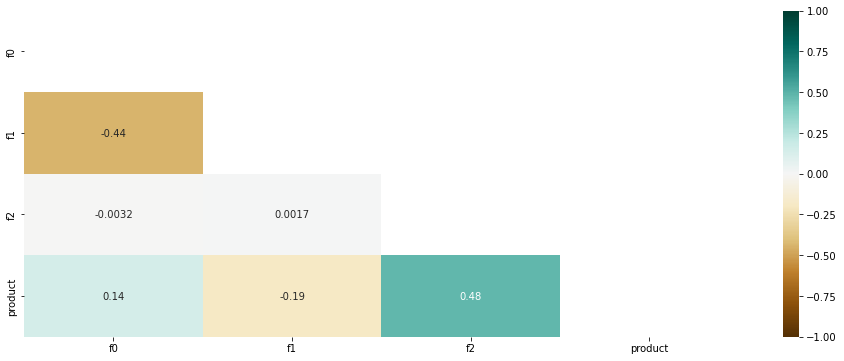

Столбцы: 

id - Уникальный идентификатор скважины

Описание данных:
count     100000
unique     99990
top        fiKDv
freq           2
Name: id, dtype: object
Количество записей: 100000 из 100000

Тип:
 <class 'str'>

f0 - Признак №0

Описание данных:
count   100,000.00
mean          0.50
std           0.87
min          -1.41
25%          -0.07
50%           0.50
75%           1.07
max           2.36
Name: f0, dtype: float64
Количество записей: 100000 из 100000

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


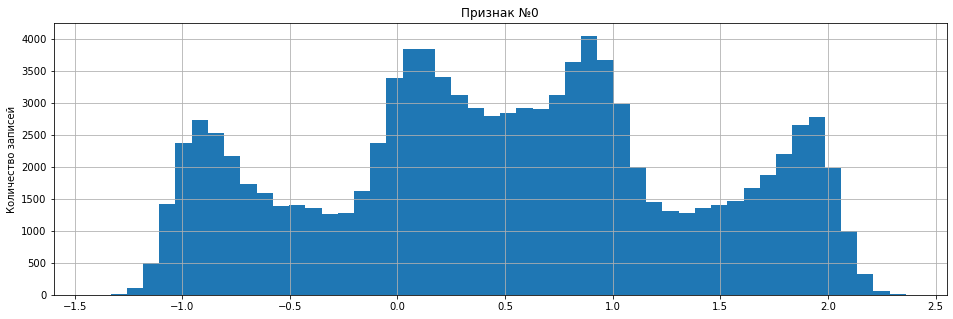


f1 - Признак №1

Описание данных:
count   100,000.00
mean          0.25
std           0.50
min          -0.85
25%          -0.20
50%           0.25
75%           0.70
max           1.34
Name: f1, dtype: float64
Количество записей: 100000 из 100000

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


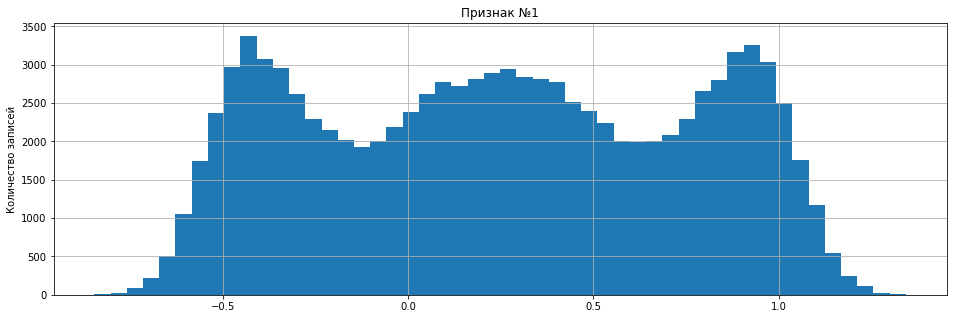


f2 - Признак №2

Описание данных:
count   100,000.00
mean          2.50
std           3.25
min         -12.09
25%           0.29
50%           2.52
75%           4.72
max          16.00
Name: f2, dtype: float64
Количество записей: 100000 из 100000

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


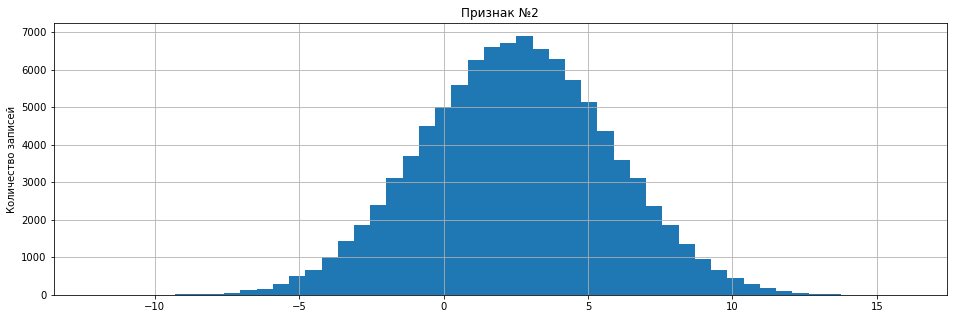


product - Объём запасов в скважине (тыс. баррелей)

Описание данных:
count   100,000.00
mean         92.50
std          44.29
min           0.00
25%          56.50
50%          91.85
75%         128.56
max         185.36
Name: product, dtype: float64
Количество записей: 100000 из 100000

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


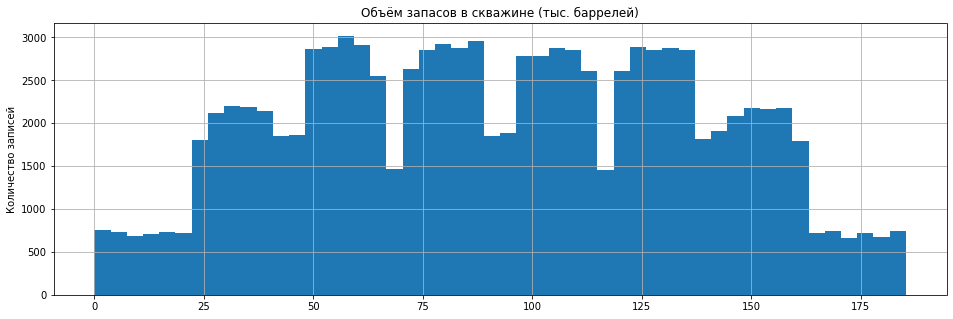

In [10]:
df_reaper(data_1, data_name+' региона №1', data_fields)

#### Дубликаты

In [11]:
data_1[data_1['id'].duplicated(keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.08,-0.31,6.99,127.64
64022,74z30,0.74,0.46,5.15,140.77
51970,A5aEY,-0.18,0.94,-2.09,33.02
3389,A5aEY,-0.04,0.16,0.21,89.25
69163,AGS9W,-0.93,0.12,-3.66,19.23
42529,AGS9W,1.45,-0.48,0.68,126.37
931,HZww2,0.76,0.37,1.86,30.68
7530,HZww2,1.06,-0.37,10.43,158.83
63593,QcMuo,0.64,-0.47,0.86,64.58
1949,QcMuo,0.51,-0.32,-2.22,75.50


Поскольку отсутствуют совпадения признаков, дубликаты, скорее всего, образовались случайным образом при шифровании названий скважин, и, на самом деле, обозначают разные скважины. Следовательно, их не требуется удалять.

#### Выделение признаков и целевого признака

Целевой признак - **product**<br />
Из оставшихся полей идентификатор скважины не влияет на выработку, поэтому исключаем его из признаков:

In [12]:
target_1 = data_1['product'] 
features_1 = data_1.drop(['id', 'product'], axis=1)

In [13]:
features_1.shape

(100000, 3)

In [14]:
target_1.shape

(100000,)

In [15]:
features_cols = features_1.columns

#### Разбивка датасета  на тренировочную и валидационную и тестовую выборку в пропорции 75:25

Поскольку у нас задача регрессии, стратификация здесь не применима

In [16]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)

In [17]:
len(features_valid_1)/len(features_train_1)

0.3333333333333333

#### Масштабирование числовых признаков

Все признаки данной модели - числовые

Посмотрим на распределение признаков

In [18]:
describer(features_train_1)

,column,count,mean,std,min,25%,50%,75%,max
0,f0,"75,000.00",0.50,0.87,-1.41,-0.08,0.50,1.07,2.36
1,f1,"75,000.00",0.25,0.50,-0.85,-0.20,0.25,0.70,1.34
2,f2,"75,000.00",2.51,3.25,-10.14,0.30,2.52,4.73,16.00


In [19]:
describer(features_valid_1)

,column,count,mean,std,min,25%,50%,75%,max
0,f0,"25,000.00",0.51,0.87,-1.30,-0.06,0.51,1.08,2.30
1,f1,"25,000.00",0.25,0.51,-0.81,-0.20,0.25,0.70,1.33
2,f2,"25,000.00",2.49,3.24,-12.09,0.26,2.51,4.69,15.01


У признаков разный масштаб. Изменим это:

In [20]:
scaler_1 = MinMaxScaler()
scaler_1.fit(features_train_1) 
features_train_1[features_cols] = scaler_1.transform(features_train_1[features_cols])
features_valid_1[features_cols] = scaler_1.transform(features_valid_1[features_cols]) 

In [21]:
describer(features_train_1)

,column,count,mean,std,min,25%,50%,75%,max
0,f0,"75,000.00",0.51,0.23,0.00,0.35,0.51,0.66,1.00
1,f1,"75,000.00",0.50,0.23,0.00,0.30,0.50,0.71,1.00
2,f2,"75,000.00",0.48,0.12,0.00,0.40,0.48,0.57,1.00


In [22]:
describer(features_valid_1)

,column,count,mean,std,min,25%,50%,75%,max
0,f0,"25,000.00",0.51,0.23,0.03,0.36,0.51,0.66,0.98
1,f1,"25,000.00",0.50,0.23,0.02,0.29,0.50,0.71,0.99
2,f2,"25,000.00",0.48,0.12,-0.07,0.40,0.48,0.57,0.96


#### Выводы

1. Датасет содержит 100 000 записей. Данные не содержат выбросов, и пропусков данных.
2. Присутствуют дубликаты в столбце "Уникальный идентификатор скважины", не требующие удаления
3. Данные синтетические, отсутствует возможность логического анализа
4. Существует ощутимая обратная корелляция между признаками №0 и №1 (-0.44)
5. Существует ощутимая корелляция между признаком  №2 и объемом запасов в скважине (0.48)
6. Выделены признаки и целевой признак
7. Датасет разбит на обучающую и валидационную выборку
8. Произведено масштабирование числовых признаков в каждой из выборок

### **Регион №2**

#### Загрузка датасета

In [23]:
data_2 = pd.read_csv('datasets/geo_data_1.csv')

#### Анализ датасета

Данные о скважинах региона №2 

Количество записей:


100000


Первые 5 строк данных:


,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77



Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Описание данных в столбцах с числовыми значениями:


,count,mean,std,min,25%,50%,75%,max
f0,"100,000.00",1.14,8.97,-31.61,-6.30,1.15,8.62,29.42
f1,"100,000.00",-4.80,5.12,-26.36,-8.27,-4.81,-1.33,18.73
f2,"100,000.00",2.49,1.70,-0.02,1.00,2.01,4.00,5.02
product,"100,000.00",68.83,45.94,0.00,26.95,57.09,107.81,137.95


Диаграмма рассеивания:


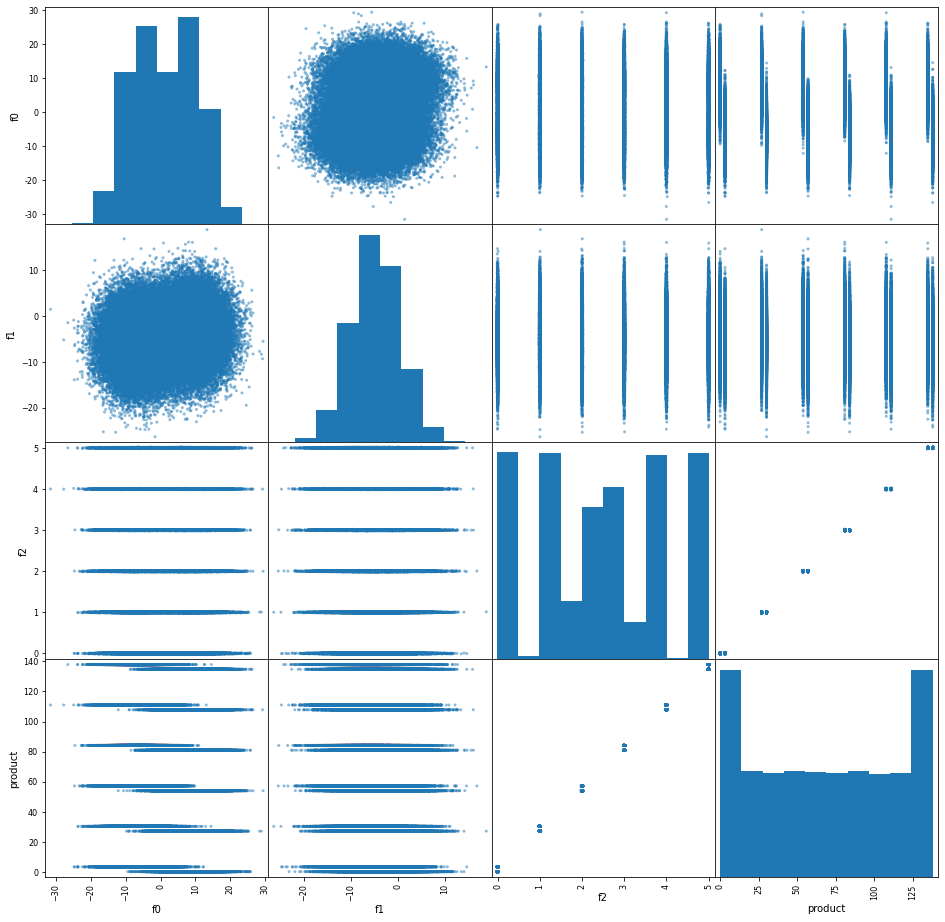

Корелляция данных:


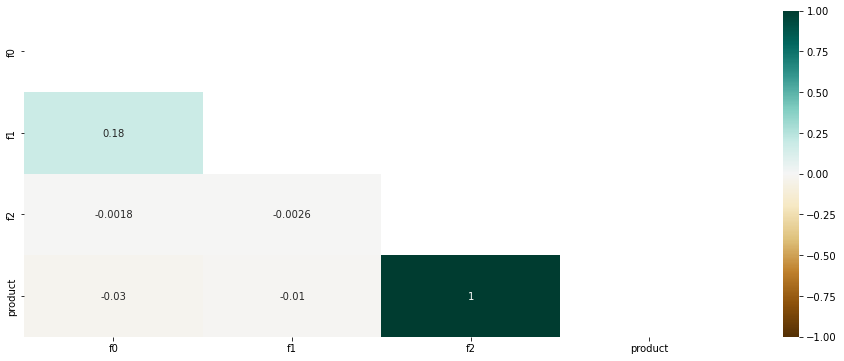

Столбцы: 

id - Уникальный идентификатор скважины

Описание данных:
count     100000
unique     99996
top        wt4Uk
freq           2
Name: id, dtype: object
Количество записей: 100000 из 100000

Тип:
 <class 'str'>

f0 - Признак №0

Описание данных:
count   100,000.00
mean          1.14
std           8.97
min         -31.61
25%          -6.30
50%           1.15
75%           8.62
max          29.42
Name: f0, dtype: float64
Количество записей: 100000 из 100000

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


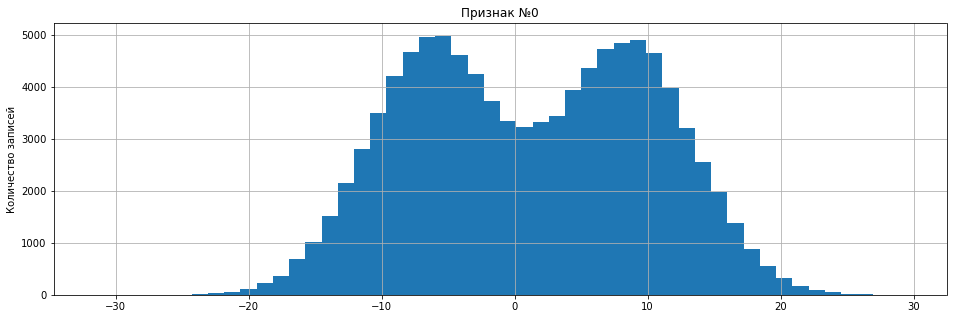


f1 - Признак №1

Описание данных:
count   100,000.00
mean         -4.80
std           5.12
min         -26.36
25%          -8.27
50%          -4.81
75%          -1.33
max          18.73
Name: f1, dtype: float64
Количество записей: 100000 из 100000

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


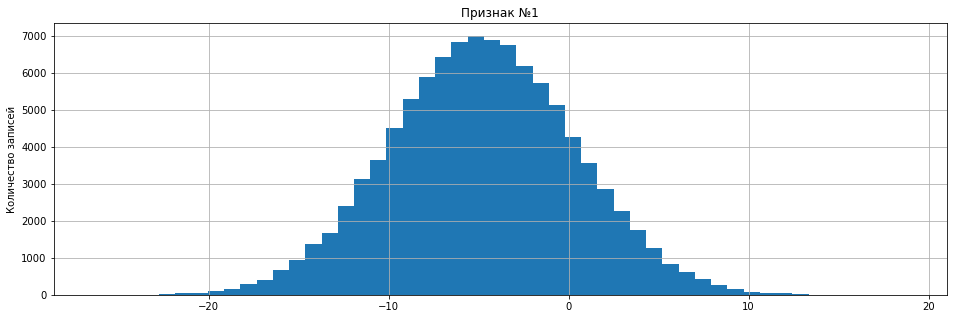


f2 - Признак №2

Описание данных:
count   100,000.00
mean          2.49
std           1.70
min          -0.02
25%           1.00
50%           2.01
75%           4.00
max           5.02
Name: f2, dtype: float64
Количество записей: 100000 из 100000

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


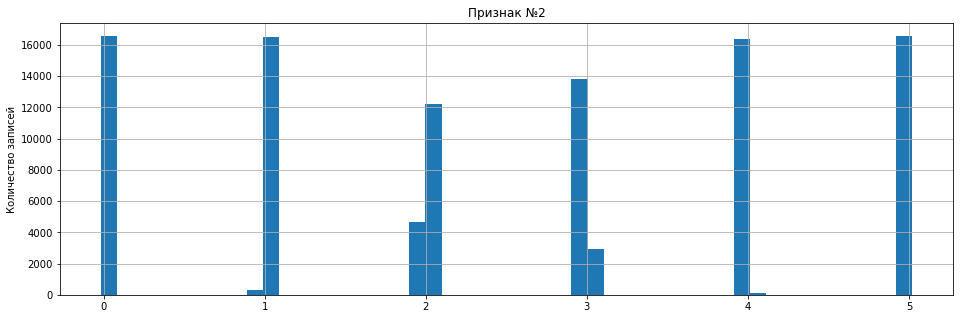


product - Объём запасов в скважине (тыс. баррелей)

Описание данных:
count   100,000.00
mean         68.83
std          45.94
min           0.00
25%          26.95
50%          57.09
75%         107.81
max         137.95
Name: product, dtype: float64
Количество записей: 100000 из 100000

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


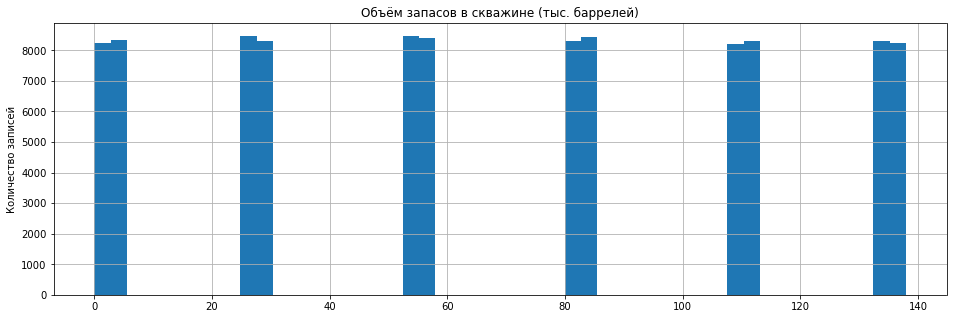

In [24]:
df_reaper(data_2, data_name+' региона №2', data_fields)

Посмотрим сколько уникальных значений содержат столбцы f2 и product

In [25]:
len(data_2['f2'].unique())

100000

Удивительно, но все они уникальны!

In [26]:
len(data_2['product'].unique())

12

В принципе (если бы не условия задачи), можно было бы подумать и о задаче классификации...

#### Дубликаты

In [27]:
data_2[data_2['id'].duplicated(keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.44,-12.30,2.00,57.09
84461,5ltQ6,18.21,2.19,3.99,107.81
1305,LHZR0,11.17,-1.95,3.00,80.86
41906,LHZR0,-8.99,-4.29,2.01,57.09
2721,bfPNe,-9.49,-5.46,4.01,110.99
82178,bfPNe,-6.20,-4.82,3.00,84.04
47591,wt4Uk,-9.09,-8.11,-0.00,3.18
82873,wt4Uk,10.26,-9.38,4.99,134.77


Поскольку отсутствуют совпадения признаков, дубликаты, скорее всего, образовались случайным образом при шифровании названий скважин, и, на самом деле, обозначают разные скважины. Следовательно, их не требуется удалять.

#### Выделение признаков и целевого признака

Целевой признак - **product**<br />
Из оставшихся полей идентификатор скважины не влияет на выработку, поэтому исключаем его из признаков:

In [28]:
target_2 = data_2['product'] 
features_2 = data_2.drop(['id', 'product'], axis=1)

In [29]:
features_2.shape

(100000, 3)

In [30]:
target_2.shape

(100000,)

#### Разбивка датасета  на тренировочную и валидационную и тестовую выборку в пропорции 75:25

С учётом особенности целевого признака, стратификация здесь применима

In [31]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345,  stratify = target_2)

In [32]:
len(features_valid_2)/len(features_train_2)

0.3333333333333333

#### Масштабирование числовых признаков

Все признаки данной модели - числовые

Посмотрим на распределение признаков

In [33]:
describer(features_train_2)

,column,count,mean,std,min,25%,50%,75%,max
0,f0,"75,000.00",1.15,8.97,-27.83,-6.28,1.15,8.63,29.26
1,f1,"75,000.00",-4.80,5.11,-26.36,-8.27,-4.82,-1.35,18.73
2,f2,"75,000.00",2.49,1.70,-0.02,1.00,2.01,4.00,5.02


In [34]:
describer(features_valid_2)

,column,count,mean,std,min,25%,50%,75%,max
0,f0,"25,000.00",1.11,8.95,-31.61,-6.35,1.17,8.59,29.42
1,f1,"25,000.00",-4.79,5.14,-25.29,-8.27,-4.80,-1.29,14.53
2,f2,"25,000.00",2.49,1.70,-0.02,1.00,2.01,4.00,5.02


У признаков разный масштаб. Изменим это:

In [35]:
scaler_2 = MinMaxScaler()
scaler_2.fit(features_train_2) 
features_train_2[features_cols] = scaler_2.transform(features_train_2[features_cols])
features_valid_2[features_cols] = scaler_2.transform(features_valid_2[features_cols]) 

In [36]:
describer(features_train_2)

,column,count,mean,std,min,25%,50%,75%,max
0,f0,"75,000.00",0.51,0.16,0.00,0.38,0.51,0.64,1.00
1,f1,"75,000.00",0.48,0.11,0.00,0.40,0.48,0.55,1.00
2,f2,"75,000.00",0.50,0.34,0.00,0.20,0.40,0.80,1.00


In [37]:
describer(features_valid_2)

,column,count,mean,std,min,25%,50%,75%,max
0,f0,"25,000.00",0.51,0.16,-0.07,0.38,0.51,0.64,1.00
1,f1,"25,000.00",0.48,0.11,0.02,0.40,0.48,0.56,0.91
2,f2,"25,000.00",0.50,0.34,-0.00,0.20,0.40,0.80,1.00


#### Выводы

1. Датасет содержит 100 000 записей. Данные не содержат выбросов, и пропусков данных.
2. Присутствуют дубликаты в столбце "Уникальный идентификатор скважины", не требующие удаления
3. Данные синтетические, отсутствует возможность логического анализа
4. Признак №2, в отличии от других регионов, сгруппирован в 5 групп, но все его значения уникальны
5. Целевой признак, в отличии от других регионов, представлен всего 12 уникальными значениями
6. Существует полная корелляция между признаком  №2 и объемом запасов в скважине
7. Выделены признаки и целевой признак
8. Датасет разбит на обучающую и валидационную выборку
9. Произведено масштабирование числовых признаков в каждой из выборок

### **Регион №3**

#### Загрузка датасета

In [38]:
data_3 = pd.read_csv('datasets/geo_data_2.csv')

#### Анализ датасета

Данные о скважинах региона №3 

Количество записей:


100000


Первые 5 строк данных:


,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60



Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Описание данных в столбцах с числовыми значениями:


,count,mean,std,min,25%,50%,75%,max
f0,"100,000.00",0.00,1.73,-8.76,-1.16,0.01,1.16,7.24
f1,"100,000.00",-0.00,1.73,-7.08,-1.17,-0.01,1.16,7.84
f2,"100,000.00",2.50,3.47,-11.97,0.13,2.48,4.86,16.74
product,"100,000.00",95.00,44.75,0.00,59.45,94.93,130.60,190.03


Диаграмма рассеивания:


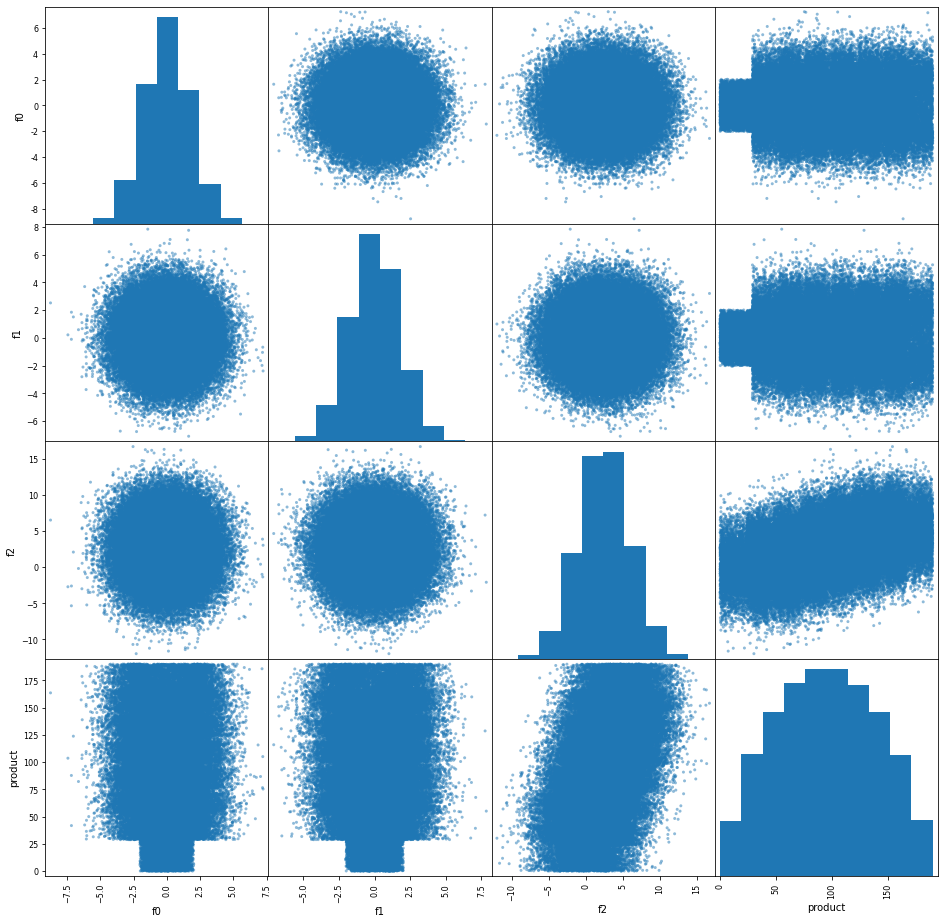

Корелляция данных:


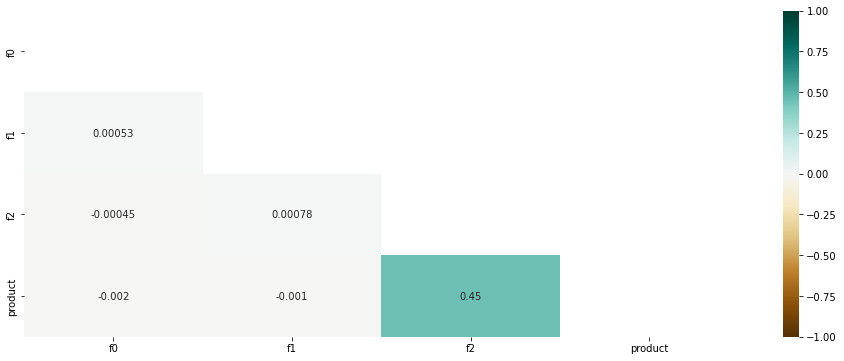

Столбцы: 

id - Уникальный идентификатор скважины

Описание данных:
count     100000
unique     99996
top        VF7Jo
freq           2
Name: id, dtype: object
Количество записей: 100000 из 100000

Тип:
 <class 'str'>

f0 - Признак №0

Описание данных:
count   100,000.00
mean          0.00
std           1.73
min          -8.76
25%          -1.16
50%           0.01
75%           1.16
max           7.24
Name: f0, dtype: float64
Количество записей: 100000 из 100000

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


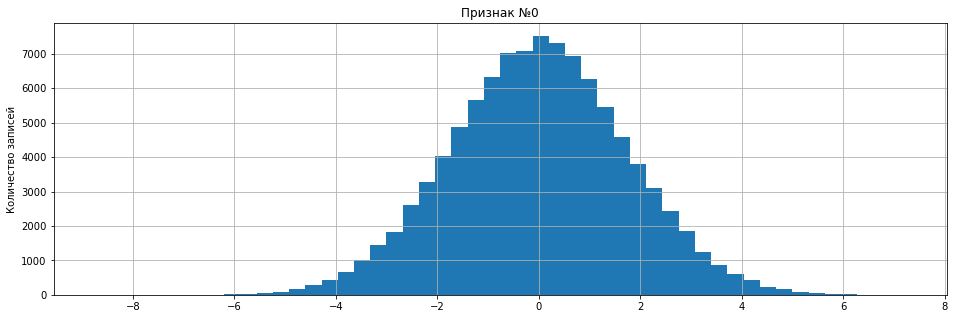


f1 - Признак №1

Описание данных:
count   100,000.00
mean         -0.00
std           1.73
min          -7.08
25%          -1.17
50%          -0.01
75%           1.16
max           7.84
Name: f1, dtype: float64
Количество записей: 100000 из 100000

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


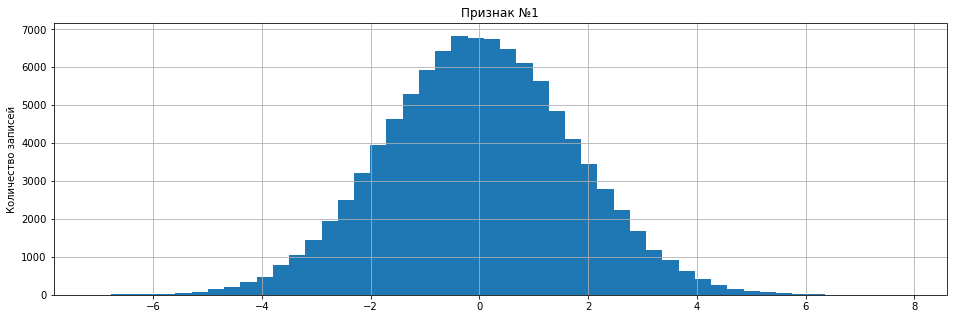


f2 - Признак №2

Описание данных:
count   100,000.00
mean          2.50
std           3.47
min         -11.97
25%           0.13
50%           2.48
75%           4.86
max          16.74
Name: f2, dtype: float64
Количество записей: 100000 из 100000

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


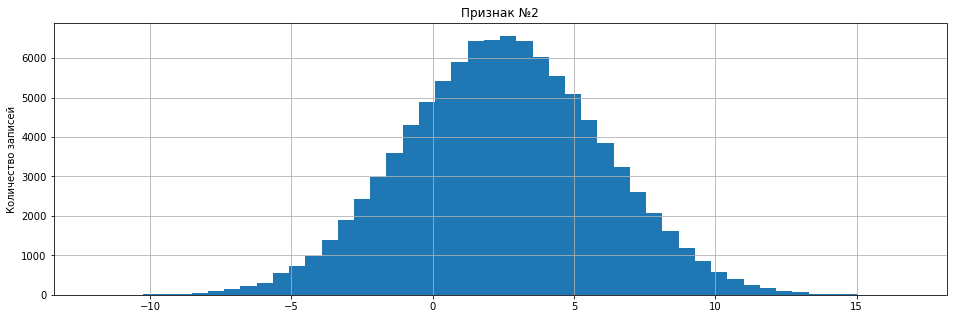


product - Объём запасов в скважине (тыс. баррелей)

Описание данных:
count   100,000.00
mean         95.00
std          44.75
min           0.00
25%          59.45
50%          94.93
75%         130.60
max         190.03
Name: product, dtype: float64
Количество записей: 100000 из 100000

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


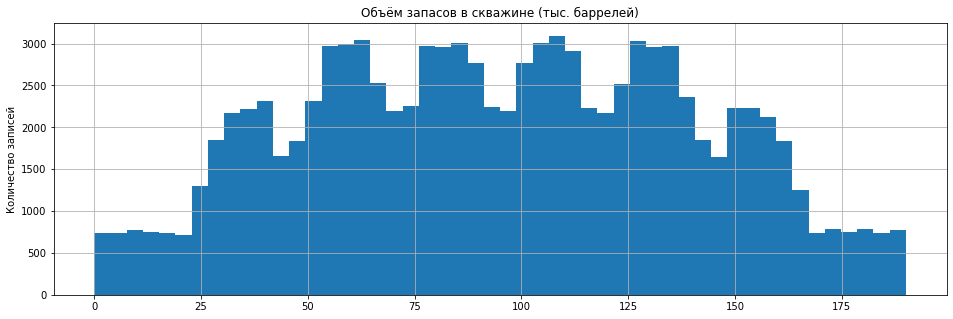

In [39]:
df_reaper(data_3, data_name+' региона №3', data_fields)

#### Дубликаты

In [40]:
data_3[data_3['id'].duplicated(keep=False)].sort_values(by='id')

,id,f0,f1,f2,product
45404,KUPhW,0.23,-1.70,4.99,11.72
55967,KUPhW,1.21,3.18,5.54,132.83
11449,VF7Jo,2.12,-0.86,5.75,181.72
49564,VF7Jo,-0.88,0.56,0.72,136.23
44378,Vcm5J,-1.23,-2.44,1.22,137.97
95090,Vcm5J,2.59,1.99,2.48,92.33
28039,xCHr8,1.63,0.37,-2.38,6.12
43233,xCHr8,-0.85,2.10,5.60,184.39


Поскольку отсутствуют совпадения признаков, дубликаты, скорее всего, образовались случайным образом при шифровании названий скважин, и, на самом деле, обозначают разные скважины. Следовательно, их не требуется удалять.

#### Выделение признаков и целевого признака

Целевой признак - **product**<br />
Из оставшихся полей идентификатор скважины не влияет на выработку, поэтому исключаем его из признаков:

In [41]:
target_3 = data_3['product'] 
features_3 = data_3.drop(['id', 'product'], axis=1)

In [42]:
features_3.shape

(100000, 3)

In [43]:
target_3.shape

(100000,)

#### Разбивка датасета  на тренировочную и валидационную и тестовую выборку в пропорции 75:25

Поскольку у нас задача регрессии, стратификация здесь не применима

In [44]:
features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(
    features_3, target_3, test_size=0.25, random_state=12345)

In [45]:
len(features_valid_3)/len(features_train_3)

0.3333333333333333

#### Масштабирование числовых признаков

Все признаки данной модели - числовые

Посмотрим на распределение признаков

In [46]:
describer(features_train_3)

,column,count,mean,std,min,25%,50%,75%,max
0,f0,"75,000.00",0.00,1.73,-8.76,-1.16,0.01,1.16,7.24
1,f1,"75,000.00",-0.01,1.73,-7.08,-1.18,-0.01,1.16,7.84
2,f2,"75,000.00",2.50,3.47,-11.97,0.14,2.48,4.86,16.74


In [47]:
describer(features_valid_3)

,column,count,mean,std,min,25%,50%,75%,max
0,f0,"25,000.00",-0.01,1.73,-7.19,-1.17,0.00,1.16,6.25
1,f1,"25,000.00",0.01,1.73,-6.75,-1.16,0.00,1.16,6.82
2,f2,"25,000.00",2.49,3.48,-11.15,0.11,2.50,4.85,14.92


У признаков разный масштаб. Изменим это. <br />
Поскольку данные по 3 участку имеют нормальное распределение, используем StandardScaler

In [48]:
scaler_3 = StandardScaler()
scaler_3.fit(features_train_1) 
features_train_3[features_cols] = scaler_3.transform(features_train_3[features_cols])
features_valid_3[features_cols] = scaler_3.transform(features_valid_3[features_cols]) 

In [49]:
describer(features_train_3)

,column,count,mean,std,min,25%,50%,75%,max
0,f0,"75,000.00",-2.17,7.49,-40.08,-7.20,-2.14,2.82,29.12
1,f1,"75,000.00",-2.20,7.53,-32.98,-7.31,-2.24,2.88,31.93
2,f2,"75,000.00",16.21,27.93,-100.19,-2.75,16.06,35.21,130.77


In [50]:
describer(features_valid_3)

,column,count,mean,std,min,25%,50%,75%,max
0,f0,"25,000.00",-2.21,7.49,-33.28,-7.26,-2.17,2.84,24.83
1,f1,"25,000.00",-2.15,7.51,-31.52,-7.22,-2.17,2.88,27.49
2,f2,"25,000.00",16.10,27.98,-93.57,-3.03,16.18,35.16,116.13


#### Выводы

1. Датасет содержит 100 000 записей. Данные не содержат выбросов, и пропусков данных.
2. Присутствуют дубликаты в столбце "Уникальный идентификатор скважины", не требующие удаления
3. Данные синтетические, отсутствует возможность логического анализа
4. Признаки №№ 0, 1 и 2, в отличии от других регионов, имеют нормальное распределение.
5. Существует ощутимая корелляция между признаком  №2 и объемом запасов в скважине (0.45)
6. Выделены признаки и целевой признак
7. Датасет разбит на обучающую и валидационную выборку
8. Произведено масштабирование числовых признаков в каждой из выборок

### **Итог этапа:**

1. Загружены данные для каждого из регионов. Каждый датасет содержит 100 000 записей.
2. В каждом из датесетов присутствуют дубликаты в столбце "Уникальный идентификатор скважины", не требующие удаления.
3. Данные синтетические, отсутствует возможность логического анализа.
4. Для Региона №2, в отличии от других регионов, признак №2 сгруппирован в 5 групп, но все его значения уникальны.
5. Корелляция данных:
- Для Региона №1 существует ощутимая корелляция между признаком №2 и объемом запасов в скважине (0.48), а также обратная корелляция между признаками №0 и №1 (-0.44);
- Для Региона №2 существует полная корелляция между признаком №2 и объемом запасов в скважине
- Для Региона №3 существует ощутимая корелляция между признаком №2 и объемом запасов в скважине (0.45)
6. Для каждого из датасетов выделены признаки и целевой признак
7. Датасеты разбит на обучающие и валидационные выборки в пропорции 3:1
8. Произведено масштабирование числовых признаков в каждой из выборок

## **Обучение и проверка модели**

### Функция моделирования

In [51]:
def modeling(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = pd.Series(model.predict(features_valid))
    predict_mean = predictions_valid.mean()
    print('Cредний запас предсказанного сырья: \t {:.2f} тыс. бареллей'.format(predict_mean))
    target_mean = pd.concat([target_train,target_valid]).mean()
    print('Cредний запас сырья в исходных данных: \t {:.2f} тыс. бареллей'.format(target_mean))
    delta = abs((target_mean-predict_mean)/predict_mean*100)
    print('Разница: \t\t\t\t {:.2f}%'.format(delta))
    rmse = mean_squared_error(target_valid,predictions_valid) ** 0.5
    print('RMSE модели: \t\t\t\t {:.2f} тыс. бареллей'.format(rmse))
    fluct = rmse/(target_valid.max()-target_valid.min())*100
    print('Доля RMSE от диапазона значений \t {:.2f}%'.format(fluct))
    return predictions_valid

### **Регион №1**

In [52]:
predictions_valid_1 = modeling(features_train_1, target_train_1, features_valid_1, target_valid_1)

Cредний запас предсказанного сырья: 	 92.59 тыс. бареллей
Cредний запас сырья в исходных данных: 	 92.50 тыс. бареллей
Разница: 				 0.10%
RMSE модели: 				 37.58 тыс. бареллей
Доля RMSE от диапазона значений 	 20.28%


### **Регион №2**

In [53]:
predictions_valid_2 = modeling(features_train_2, target_train_2, features_valid_2, target_valid_2)

Cредний запас предсказанного сырья: 	 68.83 тыс. бареллей
Cредний запас сырья в исходных данных: 	 68.83 тыс. бареллей
Разница: 				 0.01%
RMSE модели: 				 0.89 тыс. бареллей
Доля RMSE от диапазона значений 	 0.64%


До моделирования у нас было 12 уникальных результатов, посмотрим на результаты предсказаний:

In [54]:
len(np.unique(predictions_valid_2))

25000

Все уникальные!

### **Регион №3**

In [55]:
predictions_valid_3 = modeling(features_train_3, target_train_3, features_valid_3, target_valid_3)

Cредний запас предсказанного сырья: 	 94.97 тыс. бареллей
Cредний запас сырья в исходных данных: 	 95.00 тыс. бареллей
Разница: 				 0.04%
RMSE модели: 				 40.03 тыс. бареллей
Доля RMSE от диапазона значений 	 21.07%


### **Итог этапа:**

1. Построены модели "Линейная регрессия" для каждого из трех регионов
2. Для Региона №1 средний запас предсказанного сырья - 92.59 тыс. баррелей, RMSE модели - 37.58 тыс. баррелей
3. Для Региона №2 средний запас предсказанного сырья - 68.83 тыс. баррелей, RMSE модели - 0.89 тыс. баррелей
4. Для Региона №3 средний запас предсказанного сырья - 94.97 тыс. баррелей, RMSE модели - 40.03 тыс. баррелей

## **Подготовка к расчёту прибыли**

Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.<br />
Для удобства расчётов, все денежные вычисления переводим в миллионы рублей

### Ключевые переменные

In [56]:
ALL_WELLS=500 #Исследуется точек
NUM_WELLS=200 #Выбирается для разработки
OIL_PROFIT=0.45 #Доход с 1000 бареллей (в млн. рублей)
MAX_LOSS=0.025 #Допустимая вероятность убытков
BUDGET = 10000 #Бюджет на разработку скважин в регионе (в млн. рублей)
BOOTSTRAP_SAMPLES = 1000 #Количество выборок для bootstrap

### Расчёт достаточного объёма сырья для безубыточной разработки новой скважины

Бюджет на разработку скважин в регионе — 10 млрд рублей (на 200 скважин).
Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
Следовательно достаточный объём сырья для безубыточной разработки новой скважины (в тыс. барелей):

In [57]:
null_profit = BUDGET/OIL_PROFIT/NUM_WELLS
null_profit

111.11111111111111

То есть, объём сырья для безубыточной разработки новой скважины значительно больше среднего запаса сырья в скважинах в каждом из регионов.

### Функция расчёта прибыли

Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 4.1. Выберите скважины с максимальными значениями предсказаний. 
 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
 4.3. Рассчитайте прибыль для полученного объёма сырья.

In [58]:
def calc_profit(predicted, target):
    global NUM_WELLS
    global OIL_PROFIT
    global BUDGET
        
    predicted = predicted.reset_index(drop=True)
    target = target.reset_index(drop=True)
    predicted_select = predicted.sort_values(ascending=False)
    target_select =  target[predicted_select.index]
    sum_profit = target_select.head(NUM_WELLS).sum() * OIL_PROFIT - BUDGET
    return sum_profit

Проверим функцию на валидационных выборках:

In [59]:
print('Прибыль на участке №1 составляет {:.2f} млн. руб.'.format(calc_profit(predictions_valid_1, target_valid_1)))
print('Прибыль на участке №2 составляет {:.2f} млн. руб.'.format(calc_profit(predictions_valid_2, target_valid_2)))
print('Прибыль на участке №3 составляет {:.2f} млн. руб.'.format(calc_profit(predictions_valid_3, target_valid_3)))

Прибыль на участке №1 составляет 3320.83 млн. руб.
Прибыль на участке №2 составляет 2415.09 млн. руб.
Прибыль на участке №3 составляет 2710.35 млн. руб.


Мы получили высокие значения прибыли для всех участков. Но это было сделано по случайно выбранным 25000 точкам валидационной выборки, тогда как в условиях задачи при разведке региона исследуют только 500 точек.

### Итог этапа

1. Заданы константы для ключевых переменных
2. Достаточный объём сырья для безубыточной разработки новой скважины - 111.11тыс. баррелей, что значительно больше среднего запаса сырья в скважинах в каждом из регионов.
3. Написана функция расчёта прибыли

## **Расчёт прибыли и рисков** 

### Функция BootStrap-а

In [63]:
def bootstraper(target,predictions):
    global ALL_WELLS
    global all_values
    global all_confidence
    
    values = []
    state = np.random.RandomState(12345)
    target_reindex = target.reset_index(drop=True)
    for i in range(BOOTSTRAP_SAMPLES):
        target_subsample = target_reindex.sample(ALL_WELLS, replace=True, random_state=state)
        predicted_subsample = predictions[target_subsample.index]
        profit = calc_profit(predicted_subsample, target_subsample)
        values.append(profit)
    values = pd.Series(values)
    all_values.append(values)
    print('Средняя выручка составляет \t {:.2f} млн. руб.'.format(values.mean()))
    lower = int(values.quantile(q=0.025))
    upper = int(values.quantile(q=0.975))
    confidence_interval = [lower,upper]
    all_confidence.append(confidence_interval)
    print('95-% доверительный интервал: \t от {:.2f} до {:.2f} млн. руб.'.format(lower, upper))
    loss = (values < 0).mean()
    print('Вероятность убытков равна \t {:.1f}%'.format(loss*100))
    if loss > MAX_LOSS:
        print('Вероятность убытков превышает допустимую (2,5 %) - регион не подходит для разработки')
    else:
        print('Вероятность убытков не превышает допустимую (2,5 %) - регион подходит для разработки')

### Расчёт

Для каждого из регионов применим BootStrap вариантов случайных 500 скважин из валидационной выборки:

In [64]:
all_values = []
all_confidence = []
print('Регион №1')
values = bootstraper(target_valid_1,predictions_valid_1)
print('\nРегион №2')
values = bootstraper(target_valid_2,predictions_valid_2)
print('\nРегион №3')
values = bootstraper(target_valid_3,predictions_valid_3)

Регион №1
Средняя выручка составляет 	 396.16 млн. руб.
95-% доверительный интервал: 	 от -111.00 до 909.00 млн. руб.
Вероятность убытков равна 	 6.9%
Вероятность убытков превышает допустимую (2,5 %) - регион не подходит для разработки

Регион №2
Средняя выручка составляет 	 442.39 млн. руб.
95-% доверительный интервал: 	 от 39.00 до 857.00 млн. руб.
Вероятность убытков равна 	 1.2%
Вероятность убытков не превышает допустимую (2,5 %) - регион подходит для разработки

Регион №3
Средняя выручка составляет 	 404.40 млн. руб.
95-% доверительный интервал: 	 от -163.00 до 950.00 млн. руб.
Вероятность убытков равна 	 7.6%
Вероятность убытков превышает допустимую (2,5 %) - регион не подходит для разработки


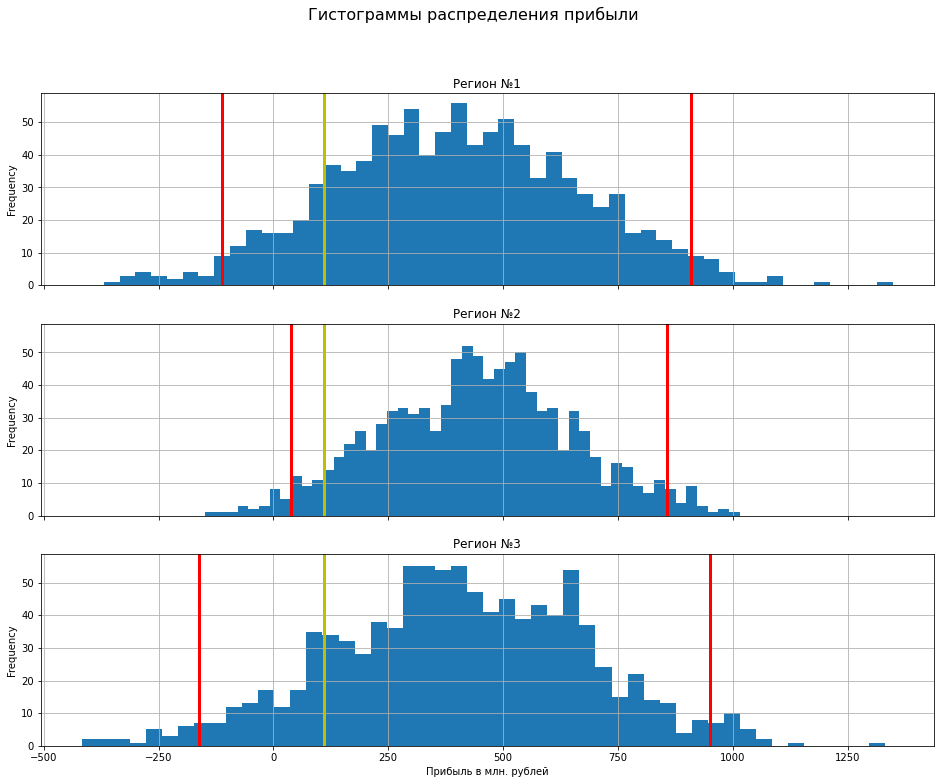

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16,12),sharex='all',sharey='all')

n = 0

for axx in axes.flat:
    axx.set(title='Регион №'+str(n+1), xlabel='Прибыль в млн. рублей')
    all_values[n].plot(kind='hist',bins=50, grid = True, ax=axx)
    # левая граница доверительного интервала
    left_0, left_1 = [all_confidence[n][0],all_confidence[n][0]], [0, 60]
    # правая граница доверительного интервала
    right_0, right_1 = [all_confidence[n][1],all_confidence[n][1]], [0, 60]
    #plt.plot(left_0, left_1, right_0, right_1, marker = 'o', ax=axx)
    axx.axvline(x=all_confidence[n][0], ymin=0, ymax=60, linewidth=3, color='r')
    axx.axvline(x=all_confidence[n][1], ymin=0, ymax=60, linewidth=3, color='r')
    axx.axvline(x=null_profit, ymin=0, ymax=60, linewidth=3, color='y')
    n += 1
    
fig.suptitle('Гистограммы распределения прибыли', fontsize=16)   
plt.show()

На гистограммах красными линиями обозначены границы 95-% доверительного интервала, а желтой - объём сырья для безубыточной разработки новой скважины

### **Итог этапа:**

1. Для каждого из регионов проведен расчет средней выручки, 95% доверительного итервала и вероятности убытков<br /> 
с использованием BootStrap-а вариантов случайных 500 скважин из валидационной выборки
2. Для Региона №1 
- средняя выручка равна 396.2 млн. руб., 
- 95% доверительный интервал от -111 до 909 млн. руб.
- вероятность убытков: 6.9%
3. Для Региона №2 
- средняя выручка равна 442.4 млн. руб., 
- 95% доверительный интервал от 39 до 857 млн. руб. 
- вероятность убытков: 1.2%
4. Для Региона №3 
- средняя выручка равна 442.4 млн. руб., 
- 95% доверительный интервал от -163 до 950 млн. руб. 
- вероятность убытков: 7.6%
5. Исходя из условий задачи, для разработки новых скважин рекомендуется регион №2, поскольку только в нем вероятность убытков меньше допустимых 2,5%
6. Перед окончательным принятием решения рекомендуется проанализировать корректность критерия №2 этого региона с учётом его физического значения из-за его распределения и полной корреляции с целевым признаком.

## Итог проекта:
    

**Загрузка и подготовка данных**
1. Загружены данные для каждого из регионов. Каждый датасет содержит 100 000 записей.
2. В каждом из датесетов присутствуют дубликаты в столбце "Уникальный идентификатор скважины", не требующие удаления.
3. Данные синтетические, отсутствует возможность логического анализа.
4. Для Региона №2, в отличии от других регионов, признак №2 сгруппирован в 5 групп, но все его значения уникальны.
5. Корелляция данных:
- Для Региона №1 существует ощутимая корелляция между признаком №2 и объемом запасов в скважине (0.48), а также обратная корелляция между признаками №0 и №1 (-0.44);
- Для Региона №2 существует полная корелляция между признаком №2 и объемом запасов в скважине
- Для Региона №3 существует ощутимая корелляция между признаком №2 и объемом запасов в скважине (0.45)
6. Для каждого из датасетов выделены признаки и целевой признак
7. Датасеты разбит на обучающие и валидационные выборки в пропорции 3:1
8. Произведено масштабирование числовых признаков в каждой из выборок

**Обучение и проверка модели**
1. Построены модели "Линейная регрессия" для каждого из трех регионов
2. Для Региона №1 средний запас предсказанного сырья - 92.59 тыс. баррелей, RMSE модели - 37.58 тыс. баррелей
3. Для Региона №2 средний запас предсказанного сырья - 68.83 тыс. баррелей, RMSE модели - 0.88 тыс. баррелей
4. Для Региона №3 средний запас предсказанного сырья - 94.97 тыс. баррелей, RMSE модели - 40.03 тыс. баррелей

**Подготовка к расчёту прибыли**
1. Заданы константы для ключевых переменных
2. Достаточный объём сырья для безубыточной разработки новой скважины - 111.11тыс. баррелей, что значительно больше среднего запаса сырья в скважинах в каждом из регионов.
3. Написана функция расчёта прибыли

**Расчёт прибыли и рисков**
1. Для каждого из регионов проведен расчет средней выручки, 95% доверительного итервала и вероятности убытков<br /> 
с использованием BootStrap-а вариантов случайных 500 скважин из валидационной выборки
2. Для Региона №1 
- средняя выручка равна 396.2 млн. руб., 
- 95% доверительный интервал от -111 до 909 млн. руб.
- вероятность убытков: 6.9%
3. Для Региона №2 
- средняя выручка равна 442.4 млн. руб., 
- 95% доверительный интервал от 39 до 857 млн. руб. 
- вероятность убытков: 1.2%
4. Для Региона №3 
- средняя выручка равна 442.4 млн. руб., 
- 95% доверительный интервал от -163 до 950 млн. руб. 
- вероятность убытков: 7.6%

**Результат**<br />
Исходя из условий задачи, для разработки новых скважин рекомендуется регион №2, поскольку только в нем вероятность убытков меньше допустимых 2,5%. <br />
Однако, перед окончательным принятием решения рекомендуется проанализировать корректность критерия №2 этого региона с учётом его физического значения, из-за его распределения и полной корреляции с целевым признаком.